<a href="https://colab.research.google.com/github/nys726/first/blob/master/numtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##미션 :

- 데이터획득: .mat 에서 x, y 를 가져옵니다
- 전처리 : x, y 를 학습할 수 있게 만듭니다
- x : (h,w,c,m) > (m,h,w,c) 로 수정
- y : (m,1) > (m) 로 수정
- y 의 라벨을 확인하세요. 숫자 0 의 라벨이 '10'입니다. 이것을 0으로 수정하세요
- 모델 생성: CNN, RNN, CRNN 등의 모델을 만듭니다
- 학습 및 평가: 데이터를 학습시키고 성능을 측정합니다

In [0]:
%tensorflow_version 2.0x
import tensorflow as tf
from tensorflow import keras
from google.colab import files

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0x`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
# 파일 업로드 방식
uploaded = files.upload()

Saving test_32x32.mat to test_32x32.mat


In [0]:
from scipy import io
mat_file = io.loadmat('test_32x32.mat')

In [0]:
mat_file 

{'X': array([[[[ 38, 129, 150, ..., 115,  96, 101],
          [103, 142, 160, ..., 132,  65,  75],
          [ 60, 153, 169, ..., 142,  47,  60]],
 
         [[ 39, 127, 150, ..., 116,  97, 100],
          [104, 143, 163, ..., 133,  65,  73],
          [ 61, 152, 170, ..., 143,  49,  60]],
 
         [[ 39, 125, 152, ..., 117,  97,  99],
          [104, 143, 168, ..., 134,  65,  71],
          [ 62, 151, 172, ..., 144,  50,  59]],
 
         ...,
 
         [[ 41, 121, 153, ..., 114,  86,  95],
          [102, 133, 172, ..., 136,  61,  63],
          [ 61, 153, 180, ..., 141,  54,  52]],
 
         [[ 42, 123, 150, ..., 114,  87,  95],
          [103, 134, 171, ..., 136,  62,  63],
          [ 62, 156, 181, ..., 142,  55,  52]],
 
         [[ 39, 123, 147, ..., 115,  88,  96],
          [ 97, 135, 169, ..., 136,  63,  64],
          [ 57, 157, 180, ..., 143,  56,  51]]],
 
 
        [[[ 39, 134, 150, ..., 122,  96, 109],
          [104, 150, 160, ..., 139,  65,  84],
          [ 61, 16

In [0]:
x = mat_file['X']
y = mat_file['y']

In [0]:
# (width, height, channels, size) -> (size, width, height, channels)
x, y = x.transpose((3,0,1,2)), y[:,0]

print("Test Set", x.shape)
print('')

num_images = x.shape[0]

print("Total Number of Images", num_images)

Test Set (26032, 32, 32, 3)

Total Number of Images 26032


In [0]:
y[:100]

array([ 5,  2,  1, 10,  6,  1,  9,  1,  1,  8,  3,  6,  5,  1,  4,  4,  1,
        6,  3,  4,  2, 10,  1,  3,  2,  5,  4,  1,  4,  2,  8,  3,  8,  6,
       10,  1,  5,  1,  1,  2,  9,  1,  6,  9,  2,  6,  1,  2, 10,  6,  9,
        1,  5,  1,  9,  8,  1,  5,  1,  5,  2,  9,  2,  4,  1, 10,  6,  9,
        3,  2,  3,  5,  1,  1,  4,  6,  2,  8,  3,  1,  4,  1,  7,  1,  2,
        1,  7,  1, 10,  1,  4,  4,  6,  4,  4,  2,  8,  1,  7,  7],
      dtype=uint8)

In [0]:
y[y==10] = 0

In [0]:
x.shape, y.shape

((26032, 32, 32, 3), (26032,))

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.datasets import load_digits
import tensorflow as tf
import scipy.io as sio
import time
import matplotlib.pyplot as plt

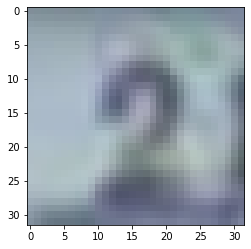

In [0]:
plt.imshow(x[1])

In [0]:
#전문가 모델
class MyModel(keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()#상속한 클래스의 생성자 호출 
    self.opt = tf.optimizers.RMSprop(learning_rate=0.01)#Stochatic Gradient Descent 확률적 경사 하강
    # RMSprop 최적화 프로그램
    self.conv0 = keras.layers.Conv2D(3, [3,3], padding='same', activation=keras.activations.relu)
    self.conv1 = keras.layers.Conv2D(6, [3,3], padding='same', activation=keras.activations.relu)
    self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(units=10, activation=keras.activations.softmax)
  
  def call(self, x):
    x_4d = tf.reshape(x, [-1,32,32,3]) / 255
    x_4d = tf.cast(x_4d, tf.float32)
    net = self.conv0(x_4d)
    net = self.pool0(net)
    net = self.conv1(net)
    net = self.pool1(net)
    net = self.flatten(net)    
    h = self.dense(net)
    return h

  def get_loss(self, y, h):
    #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
    h = tf.clip_by_value(h, 1e-6, 1 - 1e-6) # h 가 0이나 1이 되지 않도록 하는 안전장치 
    cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
    loss = tf.reduce_mean(cross_entropy)
    return loss

  def get_accuracy(self, y, h):    
    predict = tf.argmax(h, -1)
    self.acc = tf.reduce_mean(tf.cast(tf.equal(y, predict), tf.float32)) # True > 1, False > 0 로 cast

  def fit(self, x, y, epoch=1):
    # x : (m, 4), y: (m)    
    y_hot = tf.one_hot(y, depth=10, axis=-1)#(m, 3)  
    for i in range(epoch):
      with tf.GradientTape() as tape: #경사 기록 장치
        h = self.call(x)
        loss = self.get_loss(y_hot, h)        
      grads = tape.gradient(loss, self.trainable_variables) #경사 계산
      self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
      self.get_accuracy(y, h)
      if i%10==0:
        print('%d/%d loss:%.3f acc:%.3f'%(i, epoch, loss, self.acc))
model = MyModel()

In [0]:
model.fit(x[:500], y[:500], epoch=500) #학습

0/500 loss:0.331 acc:0.056
10/500 loss:0.312 acc:0.196
20/500 loss:0.301 acc:0.224
30/500 loss:0.280 acc:0.342
40/500 loss:0.271 acc:0.316
50/500 loss:0.238 acc:0.470
60/500 loss:0.237 acc:0.466
70/500 loss:0.196 acc:0.556
80/500 loss:0.195 acc:0.580
90/500 loss:0.126 acc:0.762
100/500 loss:0.136 acc:0.692
110/500 loss:0.119 acc:0.776
120/500 loss:0.095 acc:0.824
130/500 loss:0.085 acc:0.844
140/500 loss:0.086 acc:0.820
150/500 loss:0.100 acc:0.782
160/500 loss:0.069 acc:0.888
170/500 loss:0.092 acc:0.806
180/500 loss:0.100 acc:0.798
190/500 loss:0.040 acc:0.938
200/500 loss:0.043 acc:0.920
210/500 loss:0.032 acc:0.964
220/500 loss:0.031 acc:0.962
230/500 loss:0.035 acc:0.954
240/500 loss:0.021 acc:0.972
250/500 loss:0.038 acc:0.948
260/500 loss:0.074 acc:0.844
270/500 loss:0.041 acc:0.930
280/500 loss:0.012 acc:0.992
290/500 loss:0.015 acc:0.988
300/500 loss:0.009 acc:0.994
310/500 loss:0.071 acc:0.862
320/500 loss:0.008 acc:0.994
330/500 loss:0.007 acc:0.996
340/500 loss:0.010 acc:0.

In [0]:
## 모델 생성
epoch = 100
batch_m = 1000 # 메모리가 부족한 경우 데이터를 배치단위로 나누어서 학습시킵니다.
for i in range(epoch):
  iteration = np.ceil(len(y)/batch_m)
  for j in range(iteration):
    start = i*batch_m
    end = (i+1)*batch_m
    x_batch = x[start:end]
    y_batch = y[start:end]